# Clean Data

This notebook intends to clean the Raw DataFrame having as outcome one or more interim DataFrame, ready to has the features engineered (next step).
The Clean Data steps that might be followed in order to clean the Raw DataFrame are:
1. NaN
2. Features that has same value in all rows
3. Duplicated Features(identical to other existent column)
4. High Correlation Features
5. Window Selection (0-2)

## Import Needed Libraries

In [2]:
import pandas as pd #Data Analysis and manipulation tool
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Raw DataFrame

In [3]:
# Read raw file from the web
df = pd.read_excel('../data/raw/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx' )
pd.set_option('max_columns', df.shape[1]) #Adjust the plotting visualizationto make all columns visible in a plot
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Understanding the DataFrame

Note: All the information bellow was extracted from kaggle's [COVID-19 - Clinical Data to assess diagnosis Dataset](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), provided by **Sírio-Libanês data for AI and Analytics by Data Intelligence Team**

>    ### The Data (Raw DataFrame)
>    #### Label Output
>    ICU should be considered, as the first version of this dataset, the target variable.
>    #### Window Concept
>    We were carefull to include real life cenarios of with window of events and available data.
>    Data was obtain and grouped
>    * patient
>    * patient encounter
>    * aggregated by windows in chronological order>
>
>    |Window|Description|
>    |------|-----------|
>    |0-2|From 0 to 2 hours of the admission|
>    |2-4|From 2 to 4 hours of the admission|
>    |4-6|From 4 to 6 hours of the admission|
>    |6-12|From 6 to 12 hours of the admission|
>    |Above-12|Above 12 hours from admission|
>    * Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.<br><br>
>    Examples:<br>
>    ![alt text](../img/Timeline_Example_Best.png "Timeline_Example_Best")
>    ![alt text](../img/Timeline_Example_No.png "Timeline_Example_No")<br>
>    #### Dataset
>    This dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. All data were anonymized following the best international practices and recommendations.<br>Data has been cleaned and scaled by column according to Min Max Scaler to fit between -1 and 1.<br>
>    #### Available data
>    1. Patient demographic information (03)
>    2. Patient previous grouped diseases (09)
>    3. Blood results (36)
>    4. Vital signs (06)
>    <br>
>
>    In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.
>    1. diff = max - min
>    2. relative diff = diff/median

### Raw DataFrame Normalization
The data is not normalized (as it would be on a relational DataBase). It means that there is not a single row per entity (PATIENT_VISIT_IDENTIFIER), and instead of that, there exists five rows per patient, one for each time window (0-2, 2-4, 4-6, 6-12 and more than 12)

### Patient Visit Identifier
The PATIENT VISIT IDENTIFIER is not the Patient ID.
It means that if during the data logging time at the hospital, the same patient has entered two times with COVID-19 simptoms, in two different period of time, the same patient will receive two different PATIENT VISIT IDENTIFIER number instead of a unique Patient ID for both hospital admission.<br>
It probably was done in order to keep the anonimization of the patients, once it helps to preserves the identiy of those who seatch by the hospital healthcare in a short period of time. A minor part of the patient have this kind of behaviour and is relatively to identify a patient like that.<br>

### Series of measurements


## Missing Data
Note: All the information bellow was extracted from kaggle's [COVID-19 - Clinical Data to assess diagnosis Dataset](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), provided by **Sírio-Libanês data for AI and Analytics by Data Intelligence Team**
>    #### Missing data
>    *Problem*: One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).<br>
>    *Tips & Tricks*: It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, one may fill the missing values using the next or previous entry. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.

As healthcare specialists, the Data Intelligence Team of Sírio-Libanês Hospital recommend a way to deal with missing data of this dataset, using the neighborood data of the same patient to fill the missing data.<br>
This project shall follow the expert recommendation in order to deal with missing data.

In [4]:
def print_nan_count_by_feature(df: pd.DataFrame):
    '''
    Prints the number of NaN value per Feature (Column)
    '''
    nan_by_col = df.isna().sum()
    for i in range(nan_by_col.size):
        label = nan_by_col.index[i]
        nan_count = nan_by_col[i]
        print(f'{str(nan_count).zfill(4)} - {label}')

def fill_missing_data(df:pd.DataFrame, method:str)->pd.DataFrame:
    '''
    Fill the NaN Data based on Method (ffill or bfill)
    '''
    continuos_feature_columns = df.iloc[:, 13:-2].columns
    filled_coltinuous_features = df.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[continuos_feature_columns].fillna(method=method)
    categorical_features = df.iloc[:, :13]
    output = df.iloc[:, -2:]
    
    filled_concatenated_dataset = pd.concat([categorical_features, filled_coltinuous_features, output], ignore_index=True,axis=1)
    filled_concatenated_dataset.columns = df.columns
    
    
    
    return filled_concatenated_dataset

def neighborhood_missing_data(df:pd.DataFrame)->pd.DataFrame:
    '''
    Call fill missing data twice, in order to makes bfill + ffill
    '''
    bfill = fill_missing_data(df, 'bfill')
    ffill = fill_missing_data(bfill, 'ffill')
    return ffill
    

In [5]:
df_1_without_nan = neighborhood_missing_data(df)
df_1_without_nan.isna().sum().sum()

2025

In [6]:
print_nan_count_by_feature(df_1_without_nan)

0000 - PATIENT_VISIT_IDENTIFIER
0000 - AGE_ABOVE65
0000 - AGE_PERCENTIL
0000 - GENDER
0005 - DISEASE GROUPING 1
0005 - DISEASE GROUPING 2
0005 - DISEASE GROUPING 3
0005 - DISEASE GROUPING 4
0005 - DISEASE GROUPING 5
0005 - DISEASE GROUPING 6
0005 - HTN
0005 - IMMUNOCOMPROMISED
0005 - OTHER
0010 - ALBUMIN_MEDIAN
0010 - ALBUMIN_MEAN
0010 - ALBUMIN_MIN
0010 - ALBUMIN_MAX
0010 - ALBUMIN_DIFF
0010 - BE_ARTERIAL_MEDIAN
0010 - BE_ARTERIAL_MEAN
0010 - BE_ARTERIAL_MIN
0010 - BE_ARTERIAL_MAX
0010 - BE_ARTERIAL_DIFF
0010 - BE_VENOUS_MEDIAN
0010 - BE_VENOUS_MEAN
0010 - BE_VENOUS_MIN
0010 - BE_VENOUS_MAX
0010 - BE_VENOUS_DIFF
0010 - BIC_ARTERIAL_MEDIAN
0010 - BIC_ARTERIAL_MEAN
0010 - BIC_ARTERIAL_MIN
0010 - BIC_ARTERIAL_MAX
0010 - BIC_ARTERIAL_DIFF
0010 - BIC_VENOUS_MEDIAN
0010 - BIC_VENOUS_MEAN
0010 - BIC_VENOUS_MIN
0010 - BIC_VENOUS_MAX
0010 - BIC_VENOUS_DIFF
0010 - BILLIRUBIN_MEDIAN
0010 - BILLIRUBIN_MEAN
0010 - BILLIRUBIN_MIN
0010 - BILLIRUBIN_MAX
0010 - BILLIRUBIN_DIFF
0010 - BLAST_MEDIAN
0010

In [7]:
df_1_without_nan.query('UREA_MEDIAN.isnull()', engine='python')

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
995,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [8]:
df_1_without_nan = df_1_without_nan.drop(df_1_without_nan.query('UREA_MEDIAN.isnull()', engine='python').index)

In [9]:
df_1_without_nan.isna().sum().sum()

0

## Features that has same values in all observations

In [10]:
def drop_features_with_same_value_for_all_observations(df:pd.DataFrame, print_dropped_columns:bool= False)-> pd.DataFrame:
    '''
    Drop columns that has the same value in all rows
    '''
    unique = df.nunique() == 1
    if print_dropped_columns:
        for column in df.columns[unique]:
            print(column)
            
    print(f'Total of dropped columns: {sum(unique)}')
    
    return df.loc[:,~unique]

def plot_features_with_same_value_for_all_observations(df:pd.DataFrame)-> pd.DataFrame:
    '''
    Plot columns that has the same value in all rows
    '''
    unique = df.nunique() == 1            
    
    return df.loc[:,unique]

In [11]:
plot_features_with_same_value_for_all_observations(df_1_without_nan)

,ALBUMIN_DIFF,BE_ARTERIAL_DIFF,BE_VENOUS_DIFF,BIC_ARTERIAL_DIFF,BIC_VENOUS_DIFF,BILLIRUBIN_DIFF,BLAST_DIFF,CALCIUM_DIFF,CREATININ_DIFF,FFA_DIFF,GGT_DIFF,GLUCOSE_DIFF,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_DIFF,LACTATE_DIFF,LEUKOCYTES_DIFF,LINFOCITOS_DIFF,NEUTROPHILES_DIFF,P02_ARTERIAL_DIFF,P02_VENOUS_DIFF,PC02_ARTERIAL_DIFF,PC02_VENOUS_DIFF,PCR_DIFF,PH_ARTERIAL_DIFF,PH_VENOUS_DIFF,PLATELETS_DIFF,POTASSIUM_DIFF,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_DIFF,SODIUM_DIFF,TGO_DIFF,TGP_DIFF,TTPA_DIFF,UREA_DIFF,DIMER_DIFF
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1921,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1922,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1923,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
df_2_without_same_value_col = drop_features_with_same_value_for_all_observations(df_1_without_nan, True)
df_2_without_same_value_col.head()

ALBUMIN_DIFF
BE_ARTERIAL_DIFF
BE_VENOUS_DIFF
BIC_ARTERIAL_DIFF
BIC_VENOUS_DIFF
BILLIRUBIN_DIFF
BLAST_DIFF
CALCIUM_DIFF
CREATININ_DIFF
FFA_DIFF
GGT_DIFF
GLUCOSE_DIFF
HEMATOCRITE_DIFF
HEMOGLOBIN_DIFF
INR_DIFF
LACTATE_DIFF
LEUKOCYTES_DIFF
LINFOCITOS_DIFF
NEUTROPHILES_DIFF
P02_ARTERIAL_DIFF
P02_VENOUS_DIFF
PC02_ARTERIAL_DIFF
PC02_VENOUS_DIFF
PCR_DIFF
PH_ARTERIAL_DIFF
PH_VENOUS_DIFF
PLATELETS_DIFF
POTASSIUM_DIFF
SAT02_ARTERIAL_DIFF
SAT02_VENOUS_DIFF
SODIUM_DIFF
TGO_DIFF
TGP_DIFF
TTPA_DIFF
UREA_DIFF
DIMER_DIFF
Total of dropped columns: 36


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.742004,-0.945093,-0.945093,-0.945093,-0.945093,-0.891993,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,0.109756,-0.932246,-0.932246,-0.932246,-0.932246,1.000000,1.000000,1.000000,1.000000,-0.835844,-0.835844,-0.835844,-0.835844,-0.914938,-0.914938,-0.914938,-0.914938,-0.868747,-0.868747,-0.868747,-0.868747,-0.170732,-0.170732,-0.170732,-0.170732,-0.704142,-0.704142,-0.704142,-0.704142,-0.779310,-0.779310,-0.779310,-0.779310,-0.754601,-0.754601,-0.75

## Duplicated Features

In [13]:
def drop_duplicated_features(df:pd.DataFrame, print_dropped_columns:bool= False)-> pd.DataFrame:
    '''
    '''
    
    duplicated_columns = df.T.duplicated()
    if print_dropped_columns:
        for column in df.columns[duplicated_columns]:
            print(column)
    
    print(f'Total dropped columns: {sum(duplicated_columns)}')
    
    return df.loc[:,~duplicated_columns]

def plot_duplicated_features(df:pd.DataFrame)-> pd.DataFrame:
    '''
    '''
    
    duplicated_columns = df.T.duplicated()
    
    return df.loc[:,duplicated_columns]

In [14]:
plot_duplicated_features(df_2_without_same_value_col)

,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEAN,FFA_MIN,FFA_MAX,GGT_MEAN,GGT_MIN,GGT_MAX,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,INR_MEAN,INR_MIN,INR_MAX,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PCR_MEAN,PCR_MIN,PCR_MAX,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,TGO_MEAN,TGO_MIN,TGO_MAX,TGP_MEAN,TGP_MIN,TGP_MAX,TTPA_MEAN,TTPA_MIN,TTPA_MAX,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEAN,DIMER_MIN,DIMER_MAX
0,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.945093,-0.945093,-0.945093,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,-0.932246,-0.932246,-0.932246,1.000000,1.000000,1.000000,-0.835844,-0.835844,-0.835844,-0.914938,-0.914938,-0.914938,-0.868747,-0.868747,-0.868747,-0.170732,-0.170732,-0.170732,-0.704142,-0.704142,-0.704142,-0.779310,-0.779310,-0.779310,-0.754601,-0.754601,-0.754601,-0.875236,-0.875236,-0.875236,0.234043,0.234043,0.234043,0.363636,0.363636,0.363636,-0.540721,-0.540721,-0.540721,-0.518519,-0.518519,-0.518519,0.939394,0.939394,0.939394,0.345679,0.345679,0.345679,-0.028571,-0.028571,-0.028571,-0.997201,-0.997201,-0.997201,-0.990854,-0.990854,-0.990854,-0.825613,-0.825613,-0.825613,-0.836145,-0.836145,-0.836145,-0.994912,-0.994912,-0.994912
1,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.945093,-0.945093,-0.945093,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,-0.932246,-0.932246,-0.932246,1.000000,1.000000,1.000000,-0.835844,-0.835844,-0.835844,-0.914938,-0.914938,-0.914938,-0.868747,-0.868747,-0.868747,-0.170732,-0.170732,-0.170732,-0.704142,-0.704142,-0.704142,-0.779310,-0.779310,-0.779310,-0.754601,-0.754601,-0.754601,-0.875236,-0.875236,-0.875236,0.234043,0.234043,0.234043,0.363636,0.363636,0.363636,-0.540721,-0.540721,-0.540721,-0.518519,-0.518519,-0.518519,0.939394,0.939394,0.939394,0.345679,0.345679,0.345679,-0.028571,-0.028571,-0.028571,-0.997201,-0.997201,-0.997201,-0.990854,-0.990854,-0.990854,-0.825613,-0.825613,-0.825613,-0.836145,-0.836145,-0.836145,-0.994912,-0.994912,-0.994912
2,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.945093,-0.945093,-0.945093,-0.891993,-0.891993,-0.891993,0.090147,0.090147,0.090147,0.109756,0.109756,0.109756,-0.932246,-0.932246,-0.932246,1.000000,1.000000,1.000000,-0.835844

In [15]:
df_3_without_dup_col = drop_duplicated_features(df_2_without_same_value_col, True)
df_3_without_dup_col.head()

ALBUMIN_MEAN
ALBUMIN_MIN
ALBUMIN_MAX
BE_ARTERIAL_MEAN
BE_ARTERIAL_MIN
BE_ARTERIAL_MAX
BE_VENOUS_MEAN
BE_VENOUS_MIN
BE_VENOUS_MAX
BIC_ARTERIAL_MEAN
BIC_ARTERIAL_MIN
BIC_ARTERIAL_MAX
BIC_VENOUS_MEAN
BIC_VENOUS_MIN
BIC_VENOUS_MAX
BILLIRUBIN_MEAN
BILLIRUBIN_MIN
BILLIRUBIN_MAX
BLAST_MEAN
BLAST_MIN
BLAST_MAX
CALCIUM_MEAN
CALCIUM_MIN
CALCIUM_MAX
CREATININ_MEAN
CREATININ_MIN
CREATININ_MAX
FFA_MEAN
FFA_MIN
FFA_MAX
GGT_MEAN
GGT_MIN
GGT_MAX
GLUCOSE_MEAN
GLUCOSE_MIN
GLUCOSE_MAX
HEMATOCRITE_MEAN
HEMATOCRITE_MIN
HEMATOCRITE_MAX
HEMOGLOBIN_MEAN
HEMOGLOBIN_MIN
HEMOGLOBIN_MAX
INR_MEAN
INR_MIN
INR_MAX
LACTATE_MEAN
LACTATE_MIN
LACTATE_MAX
LEUKOCYTES_MEAN
LEUKOCYTES_MIN
LEUKOCYTES_MAX
LINFOCITOS_MEAN
LINFOCITOS_MIN
LINFOCITOS_MAX
NEUTROPHILES_MEAN
NEUTROPHILES_MIN
NEUTROPHILES_MAX
P02_ARTERIAL_MEAN
P02_ARTERIAL_MIN
P02_ARTERIAL_MAX
P02_VENOUS_MEAN
P02_VENOUS_MIN
P02_VENOUS_MAX
PC02_ARTERIAL_MEAN
PC02_ARTERIAL_MIN
PC02_ARTERIAL_MAX
PC02_VENOUS_MEAN
PC02_VENOUS_MIN
PC02_VENOUS_MAX
PCR_MEAN
PCR_MIN
PCR_MAX
P

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,

# Window Selection

In [16]:
# 1st path: drop from DataFrame the Patient that has entered at ICU on first window.
direct_to_icu = df_3_without_dup_col.query("WINDOW == '0-2' & ICU == 1")['PATIENT_VISIT_IDENTIFIER'].to_list()
index_to_drop = df_3_without_dup_col.query('PATIENT_VISIT_IDENTIFIER == @direct_to_icu').index
df_4_1_without_direct_to_icu = df_3_without_dup_col.drop(index_to_drop)
df_4_1_without_direct_to_icu.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.779310,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,-1.0,0.326531,-0.926398,

In [17]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [18]:
df_4_1_without_direct_to_icu = df_4_1_without_direct_to_icu.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window).drop('PATIENT_VISIT_IDENTIFIER', axis=1).reset_index().drop('level_1', axis=1)
df_4_1_without_direct_to_icu.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,

In [20]:
df_4_1_without_direct_to_icu['WINDOW'].value_counts()

0-2    351
Name: WINDOW, dtype: int64

In [21]:
df_4_1_without_direct_to_icu = df_4_1_without_direct_to_icu.drop('WINDOW', axis=1)
df_4_1_without_direct_to_icu.to_csv('../data/interim/df_4_1_without_direct_to_icu.csv')
df_4_1_without_direct_to_icu.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-

In [127]:
df_4_2_with_direct_to_icu = df_3_without_dup_col.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window).drop('PATIENT_VISIT_IDENTIFIER', axis=1).reset_index().drop('level_1', axis=1)
df_4_2_with_direct_to_icu.to_csv('../data/interim/df_4_2_with_direct_to_icu.csv')
df_4_2_with_direct_to_icu.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,HEMOGLOBIN_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,NEUTROPHILES_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.210526,-1.0,-1.0,-0.317073,-0.219512,-0.967556,-1.0,0.530612,-0.615004,-0.769723,-0.982477,-0.891993,-0.870021,-0.914634,-0.959849,-1.000000,-0.523754,-0.858921,-0.557023,-0.170732,1.000000,-0.77931,-0.496933,-0.834405,0.234043,-0.060606,-0.636849,-0.629630,0.939394,1.000000,-0.257143,-0.997014,-0.993902,-0.846633,-0.561446,-0.978029,-0.283951,-0.046154,0.188679,0.830508,-0.107143,1.000000,-0.283951,-0.046154,0.188679,0.862069,-0.107143,1.000000,-0.072165,0.1500,0.264957,1.000000,0.318681,1.000000,-0.504274,-0.329730,-0.059701,0.636364,-0.275362,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.

## High Correlation Features

<AxesSubplot:>

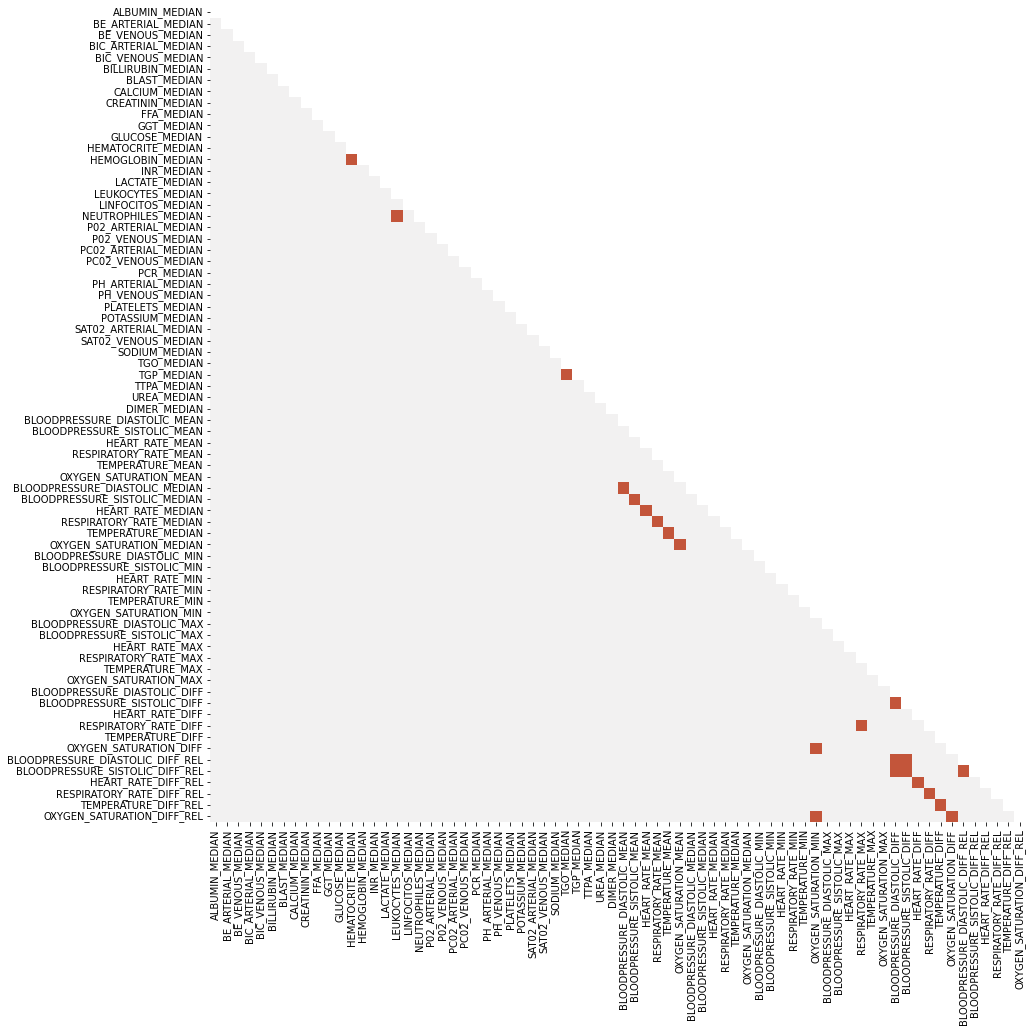

In [15]:
# Compute the correlation matrix
corr = df_3_without_dup_col.iloc[:,13:-2].corr().abs()
masked_corr = corr
masked_corr[corr <= 0.85] = 0
masked_corr[corr > 0.85] = 1

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(masked_corr, mask=mask, cmap=cmap, center=0, square=True, vmin=0, vmax=1.0, cbar=False)

In [19]:
upper_tri = masked_corr.where(np.triu(np.ones(masked_corr.shape),k=1).astype(np.bool))
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
#upper_tri

<ipython-input-19-32c696acf2e6>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = masked_corr.where(np.triu(np.ones(masked_corr.shape),k=1).astype(np.bool))


In [20]:
correlated = []
for i in range(72):
    for j in range(72):
        if upper_tri.iloc[i,j] > 0.85:
            print(f'{upper_tri.index[i]} x {upper_tri.columns[j]}')
            correlated.append([upper_tri.index[i], upper_tri.columns[j]])

HEMATOCRITE_MEDIAN x HEMOGLOBIN_MEDIAN
LEUKOCYTES_MEDIAN x NEUTROPHILES_MEDIAN
TGO_MEDIAN x TGP_MEDIAN
BLOODPRESSURE_DIASTOLIC_MEAN x BLOODPRESSURE_DIASTOLIC_MEDIAN
BLOODPRESSURE_SISTOLIC_MEAN x BLOODPRESSURE_SISTOLIC_MEDIAN
HEART_RATE_MEAN x HEART_RATE_MEDIAN
RESPIRATORY_RATE_MEAN x RESPIRATORY_RATE_MEDIAN
TEMPERATURE_MEAN x TEMPERATURE_MEDIAN
OXYGEN_SATURATION_MEAN x OXYGEN_SATURATION_MEDIAN
OXYGEN_SATURATION_MIN x OXYGEN_SATURATION_DIFF
OXYGEN_SATURATION_MIN x OXYGEN_SATURATION_DIFF_REL
RESPIRATORY_RATE_MAX x RESPIRATORY_RATE_DIFF
BLOODPRESSURE_DIASTOLIC_DIFF x BLOODPRESSURE_SISTOLIC_DIFF
BLOODPRESSURE_DIASTOLIC_DIFF x BLOODPRESSURE_DIASTOLIC_DIFF_REL
BLOODPRESSURE_DIASTOLIC_DIFF x BLOODPRESSURE_SISTOLIC_DIFF_REL
BLOODPRESSURE_SISTOLIC_DIFF x BLOODPRESSURE_DIASTOLIC_DIFF_REL
BLOODPRESSURE_SISTOLIC_DIFF x BLOODPRESSURE_SISTOLIC_DIFF_REL
HEART_RATE_DIFF x HEART_RATE_DIFF_REL
RESPIRATORY_RATE_DIFF x RESPIRATORY_RATE_DIFF_REL
TEMPERATURE_DIFF x TEMPERATURE_DIFF_REL
OXYGEN_SATURATION_DIF

In [ ]:
correlated

In [ ]:
upper_tri.index[12], upper_tri.columns[13]

In [ ]:
df_3_without_dup_col.loc[:,correlated[0]]

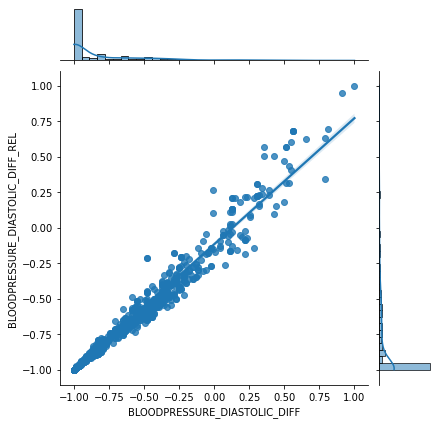

In [21]:
sns.jointplot(x="BLOODPRESSURE_DIASTOLIC_DIFF", y="BLOODPRESSURE_DIASTOLIC_DIFF_REL", data=df_3_without_dup_col, kind="reg");

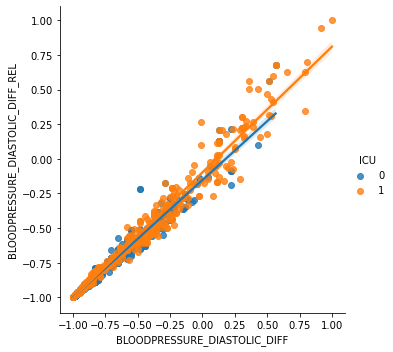

In [22]:
sns.lmplot(x="BLOODPRESSURE_DIASTOLIC_DIFF", y="BLOODPRESSURE_DIASTOLIC_DIFF_REL", hue="ICU", data=df_3_without_dup_col);

<AxesSubplot:xlabel='BLOODPRESSURE_DIASTOLIC_DIFF', ylabel='BLOODPRESSURE_DIASTOLIC_DIFF_REL'>

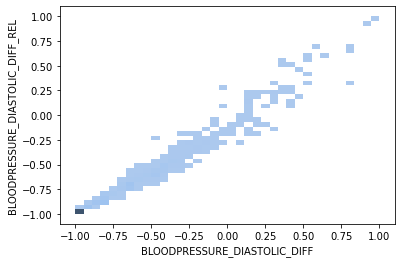

In [23]:
sns.histplot(
    df_3_without_dup_col, x="BLOODPRESSURE_DIASTOLIC_DIFF", y="BLOODPRESSURE_DIASTOLIC_DIFF_REL")

<AxesSubplot:xlabel='BLOODPRESSURE_DIASTOLIC_DIFF', ylabel='Percent'>

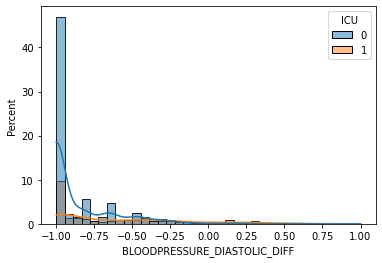

In [24]:
sns.histplot(df_3_without_dup_col, x="BLOODPRESSURE_DIASTOLIC_DIFF", hue="ICU", kde=True, stat="percent")

<AxesSubplot:xlabel='BLOODPRESSURE_DIASTOLIC_DIFF_REL', ylabel='Percent'>

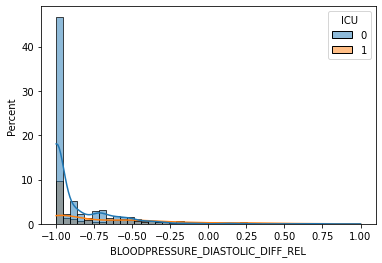

In [27]:
sns.histplot(df_3_without_dup_col, x="BLOODPRESSURE_DIASTOLIC_DIFF_REL", hue="ICU", kde=True, stat="percent")

<AxesSubplot:xlabel='BLOODPRESSURE_SISTOLIC_DIFF', ylabel='Percent'>

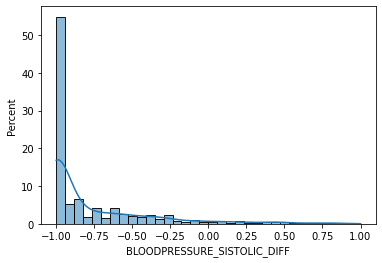

In [109]:
sns.histplot(df_3_without_dup_col.query('ICU, x="BLOODPRESSURE_SISTOLIC_DIFF", kde=True, stat="percent")